Running Q-Learning....


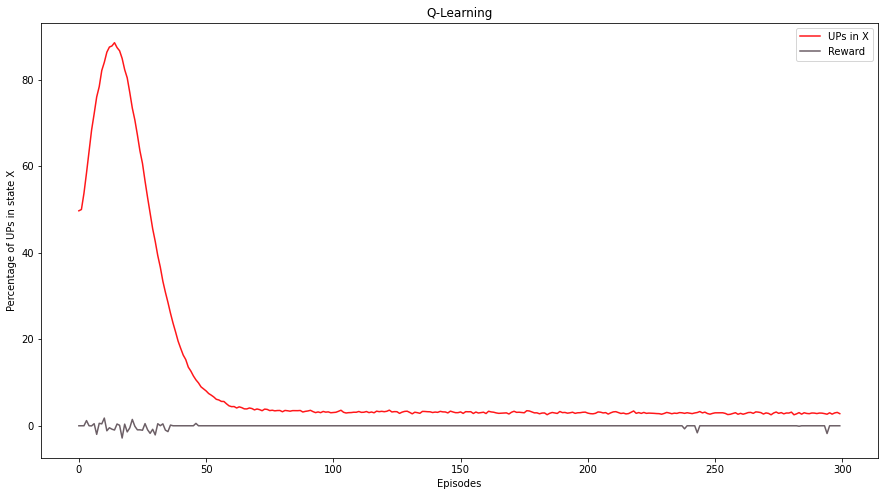

Running Double Q-Learning....


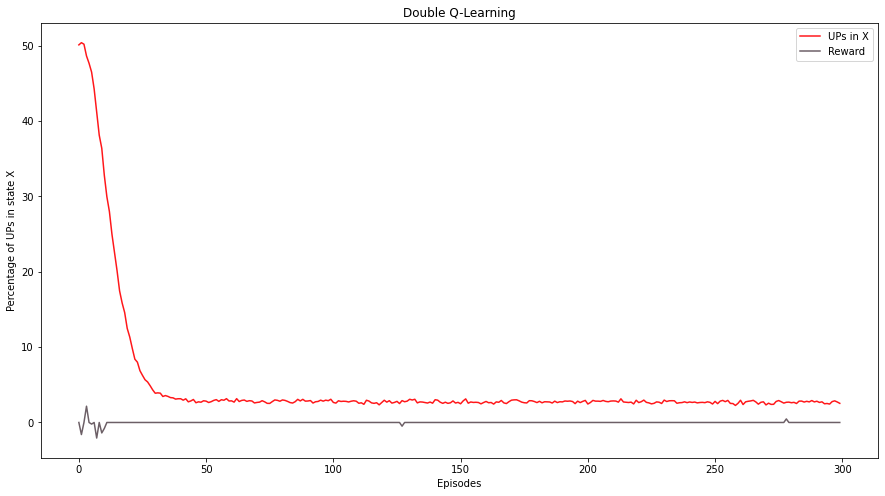

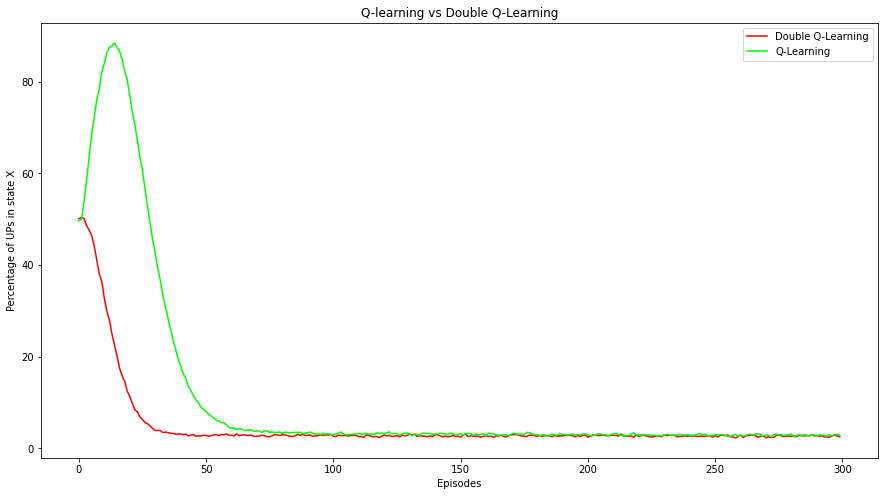

In [5]:
import numpy as np
import random
from IPython.display import clear_output
import gym
import matplotlib.pyplot as plt

# Globals
ALPHA = 0.1
GAMMA = 0.6
EPSILON = 0.05

class MDP():   
    def __init__(self, action_tree=9):
        # Actions
        self.down, self.up = 0, 1
        
        # States and posible actions
        self.state_actions = {
            'X': [self.down, self.up],
            'Y': [i for i in range(action_tree)],
            'W': [self.down], 
            'Z': [self.up] }
        
        # Transitions
        self.transitions = {
            'X': {self.down: 'Z',
                  self.up: 'Y'},
            'Y': {a: 'W' for a in range(action_tree)},
            'W': {self.down: 'Done'},
            'Z': {self.up: 'Done'}
        }
        
        self.states_space = 4
        self.action_space = action_tree
        self.state = 'X'
    
    def _get_reward(self):
        return np.random.normal(-0.5, 1) if self.state == 'W' else 0
    
    def _is_terminated_state(self):
        return True if self.state == 'W' or self.state == 'Z' else False
    
    def reset(self):
        self.state = 'X'
        return self.state
    
    def step(self, action):
        self.state = self.transitions[self.state][action]
        return self.state, self._get_reward(), self._is_terminated_state(), None
    
    def available_actions(self, state):
        return self.state_actions[state]
    
    def random_action(self):
        return np.random.choice(self.available_actions(self.state))
    
mdp_enviroment = MDP()

def mdp_q_learning(enviroment, num_of_tests = 10000, num_of_episodes=300):

    print("Running Q-Learning....")

    num_of_ups = np.zeros(num_of_episodes)
    
    for _ in range(num_of_tests):
        
        # Initialize Q-table
        q_table = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        rewards = np.zeros(num_of_episodes)

        for episode in range(0, num_of_episodes):
            # Reset the enviroment
            state = enviroment.reset()

            # Initialize variables
            terminated = False

            while not terminated:
                # Pick action a....
                if np.random.rand() < EPSILON:
                    action = enviroment.random_action()
                else:
                    available_actions = enviroment.available_actions(enviroment.state)
                    state_actions = q_table[state][available_actions]
                    max_q = np.where(np.max(state_actions) == state_actions)[0]
                    action = np.random.choice(max_q)

                # ...and get r and s'    
                next_state, reward, terminated, _ = enviroment.step(action) 

                # 'up's from state 'X'
                if state == 'X' and action == 1:
                    num_of_ups[episode] += 1

                # Update Q-Table
                max_value = np.max(q_table[next_state])
                q_table[state][action] += ALPHA * (reward + GAMMA * max_value - q_table[state][action])
                state = next_state
                rewards[episode] += reward
            
    return rewards, q_table, num_of_ups

q_reward, q_table, num_of_ups = mdp_q_learning(mdp_enviroment)

plt.figure(figsize=(15,8))
plt.plot(num_of_ups/10000*100, label='UPs in X', color='#FF171A')
plt.plot(q_reward, color='#6C5F66', label='Reward')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Q-Learning')
plt.show()


def mdp_double_q_learning(enviroment, num_of_tests = 10000, num_of_episodes=300):

    print("Running Double Q-Learning....")

    num_of_ups = np.zeros(num_of_episodes)
    
    for _ in range(num_of_tests):
        
        # Initialize Q-table
        q_a_table = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        q_b_table = {state: np.zeros(9) for state in mdp_enviroment.state_actions.keys()}
        rewards = np.zeros(num_of_episodes)

        for episode in range(0, num_of_episodes):
            # Reset the enviroment
            state = enviroment.reset()

            # Initialize variables
            terminated = False

            while not terminated:
                # Pick action a....
                if np.random.rand() < EPSILON:
                    action = enviroment.random_action()
                else:
                    q_table = q_a_table[state][enviroment.available_actions(enviroment.state)] + \
                        q_b_table[state][enviroment.available_actions(enviroment.state)]
                    max_q = np.where(np.max(q_table) == q_table)[0]
                    action = np.random.choice(max_q)

                # ...and get r and s'    
                next_state, reward, terminated, _ = enviroment.step(action) 

                # 'up's from state 'X'
                if state == 'X' and action == 1:
                    num_of_ups[episode] += 1
               
                # Update(A) or Update (B)
                if np.random.rand() < 0.5:
                    # If Update(A)
                    q_a_table[state][action] += ALPHA * (reward + GAMMA * q_b_table[next_state][np.argmax(q_a_table[next_state])] - q_a_table[state][action])

                else:
                    # If Update(B)
                    q_b_table[state][action] = ALPHA * (reward + GAMMA * q_a_table[next_state][np.argmax(q_b_table[next_state])] - q_b_table[state][action])

                
                state = next_state
                rewards[episode] += reward
            
    return rewards, q_a_table, q_b_table, num_of_ups
dq_reward, _, _, dq_num_of_ups = mdp_double_q_learning(mdp_enviroment)

plt.figure(figsize=(15,8))
plt.plot(dq_num_of_ups/10000*100, label='UPs in X', color='#FF171A')
plt.plot(dq_reward, color='#6C5F66', label='Reward')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Double Q-Learning')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(dq_num_of_ups/10000*100, label='Double Q-Learning', color='#ff0000')
# plt.figure(figsize=(15,8))
plt.plot(num_of_ups/10000*100, label='Q-Learning', color='#00ff00')
plt.legend()
plt.ylabel('Percentage of UPs in state X')
plt.xlabel('Episodes')
plt.title(r'Q-learning vs Double Q-Learning')
plt.show()